# Análisis no-lineal aproximado

## Introducción

Entre las aproximaciones fundamentales de la teoría linealizada de la elasticidad se asume que no hay diferencias importantes entre la configuración original y la configuración deformada de una estructura.

Nótese que si se desprecia esta hipótesis se hace necesario conocer la configuración deformada antes de poder plantear las ecuaciones de equilibrio pero, a la vez, para poder conocer la configuración deformada es necesario cargar el sistema y resolver las ecuaciones de equilibrio. En consecuencia el problema es no lineal.

Este puede verse en la matriz de rigidez local de un elemento cercha:

$$
\begin{Bmatrix}f_1\\f_2\end{Bmatrix} = \frac{AE}{l}
\begin{bmatrix}
1&-1\\
-1&1\end{bmatrix}
\begin{Bmatrix}u_1\\u_2\end{Bmatrix}\, ,
$$

de la cual se aprecia que la rigidez depende de la longitud del elemento, la cual depende a la vez de la deformación del mismo.

En este notebook utilizaremos la implementación de los elementos tipo cercha (desarrollada en NB anteriores) para resolver una estructura considerando de manera aproximada la no linealidad.

En particular, abordaremos el problema de una cercha de von Mises (ver figura), sometida a una carga vertical $F$. 

<center>
    <img src="images/cercha_mises.svg"
         alt="Cercha de von Mises"
         style="width:400px">
</center>


Esta cercha tiene la particularidad de que dependiendo del valor de la carga la estructura puede desarrollar un colapso por pandeo subito e invertir su configuración. Para determinar el valor de la carga de colapso es necesario:

1. Resolver el problema incrementalmente dividiendo la aplicación de la carga en varios pasos o incrementos $\triangle F$.

2. Considerar el efecto de la deformación en la solución del problema de equilibrio.

## Método de solución

Para resolver el problema se asumirá, en cada incremento, que la rigidez de los elementos, y por ende la rigidez de la estructura, corresponde a la configuración original antes de imponer el incremento de carga. Denotemos esta configuración y su rigidez asociada como ${}^0X$ y ${}^0K$ respectivamente y escribamos la ecuación de equilibrio en esta configuración como:

$$
[^0K] \{\triangle U\} = \{\triangle F \}
$$

donde $\triangle U$ sería el desplazamiento producido por $\triangle F$ si es que la rigidez fuera ${}^0K$.

<div class="alert alert-warning">
    
¿De qué depende que las rigideces correspondientes a la configuración original ${}^0K$ y deformada ${}^1K$ sean diferentes?

</div>

Para verificar que tanto se esta violando la condición de equilibrio actualicemos el sistema a la configuración deformada de acuerdo con:


$$
X_i \leftarrow{}^0X+\triangle U
$$

y en la cual $X_i$ denota la aproximación $i$ a la configuración deformada.

Recalculemos ahora la rigidez $K=K(X_i)$ en función de la nueva configuración $X_i$ y determinemos también los residuales o fuerzas sin equilibrar dadas por:

$$
R = \triangle F-K(X_i)\triangle U
$$


Una configuración de equilibrio se habrá encontrado cuando $R<tol$ o equivalentemente cuando el sistema

$$
\left[K\right]\left\{\triangle U\right\}=\left\{R\right\}
$$


arroje como resultado un incremento de desplazamiento muy pequeño o tal que $\triangle U<tol$.

Para verificar esta condición hacemos:

$$
\triangle F \leftarrow R
$$

y resolvemos

$$
\left[K\right]\left\{\triangle U\right\}=\left\{\triangle F\right\}
$$

para determinar el nuevo incremento $\triangle U$.

### Algoritmo 

If $\triangle U < Tol$ Then (estado de equilibrio encontrado):

Almacene la solución:


$$
^1X \leftarrow X_i
$$

$$
{}^1U \leftarrow {}^1X - {}^0X
$$

$$
{}^1F \leftarrow  \triangle F
$$


Else

Actualice la configuración:

$$
X_{i+1}\leftarrow{} X_i+\triangle U
$$


$$
U \leftarrow X_{i+1} - {}^0X
$$

Recalcule $K=K(X_{i+1})$


Calcule el residual:

$$
R = \triangle F-K(X_{i+1}) U
$$


y resuelva el sistema:

$$
\left[K\right]\left\{\triangle U\right\}=\left\{R\right\}
$$

para determinar un nuevo incremento $\triangle U$ hasta alcanzar convergencia.

## Solución por elementos finitos

### Subrutinas generales

In [1]:
import numpy as np
from solidspy.postprocesor import plot_truss

In [2]:
%matplotlib notebook

In [3]:
def readin():
    nodes = np.loadtxt('files/Cnodes.txt', ndmin=2)
    mats = np.loadtxt('files/Cmater.txt', ndmin=2)
    elements = np.loadtxt('files/Celes.txt', ndmin=2, dtype=np.int)
    loads = np.loadtxt('files/Cloads.txt', ndmin=2)
    return nodes, mats, elements, loads

In [4]:
def eqcounter(nodes):
    nnodes = nodes.shape[0]
    IBC = np.zeros((nnodes, 2), dtype=np.integer)
    for node in range(nnodes):
        for dof in range(2):
            IBC[node, dof] = int(nodes[node, dof + 3])
    neq = 0
    for node in range(nnodes):
        for dof in range(2):
            if IBC[node, dof] == 0:
                IBC[node, dof] = neq
                neq = neq + 1
    return neq, IBC

In [5]:
def assembly(elements, mats, nodes, neq, DME):
    IELCON = np.zeros((2), dtype=np.integer)
    KG = np.zeros((neq, neq))
    nels = elements.shape[0]
    nnodes = 2
    ndof = 4
    for el in range(nels):
        elcoor = np.zeros((nnodes, 2))
        im = np.int(elements[el, 2])
        par0 = mats[im, 0]
        par1 = mats[im, 1]
        for j in range(nnodes):
            IELCON[j] = elements[el, j+3]
            elcoor[j, 0] = nodes[IELCON[j], 1]
            elcoor[j, 1] = nodes[IELCON[j], 2]
        kloc = ueltruss2D(elcoor, par0, par1)
        dme = DME[el, :ndof]
        for row in range(ndof):
            glob_row = dme[row]
            if glob_row != -1:
                for col in range(ndof):
                    glob_col = dme[col]
                    if glob_col != -1:
                        KG[glob_row, glob_col] = KG[glob_row, glob_col] +\
                                                 kloc[row, col]
    return KG

In [6]:
def ueltruss2D(coord, A, Emod):
    vec = coord[1, :] - coord[0, :]
    length = np.linalg.norm(vec)
    nx = vec[0]/length
    ny = vec[1]/length
    Q = np.array([
        [nx, ny, 0, 0],
        [0,  0, nx, ny]])
    kl = (A*Emod/length) * np.array([
        [1, -1],
        [-1, 1]])
    kG = Q.T @ kl @ Q
    return kG

In [7]:
def loadasem(loads, IBC, neq, nl):
    RHSG = np.zeros([neq])
    for cont in range(nl):
        il = int(loads[cont, 0])
        ilx = IBC[il, 0]
        ily = IBC[il, 1]
        if ilx != -1:
            RHSG[ilx] = loads[cont, 1]
        if ily != -1:
            RHSG[ily] = loads[cont, 2]
    return RHSG

In [8]:
def DME(nodes, elements):
    nels = elements.shape[0]
    IELCON = np.zeros((nels, 2), dtype=np.integer)
    DME_mat = np.zeros((nels, 4), dtype=np.integer)
    neq, IBC = eqcounter(nodes)
    ndof = 4
    nnodes = 2
    for ele in range(nels):
        for node in range(nnodes):
            IELCON[ele, node] = elements[ele, node + 3]
            glob_num = IELCON[ele, node]
            for loc_num in range(2):
                DME_mat[ele, 2*node + loc_num] = IBC[glob_num, loc_num]
    return DME_mat, IBC, neq

Calcule el operador ensamblador y déjelo listo para iterar

In [9]:
ndof = 4
nnodes = 2
nels = 2
nodes, mats, elements, loads = readin()
neq, IBC = eqcounter(nodes)
R = np.zeros((neq))
F = np.zeros((neq))
UG = np.zeros((neq))
DME_mat, IBC, neq = DME(nodes, elements)

<IPython.core.display.Javascript object>


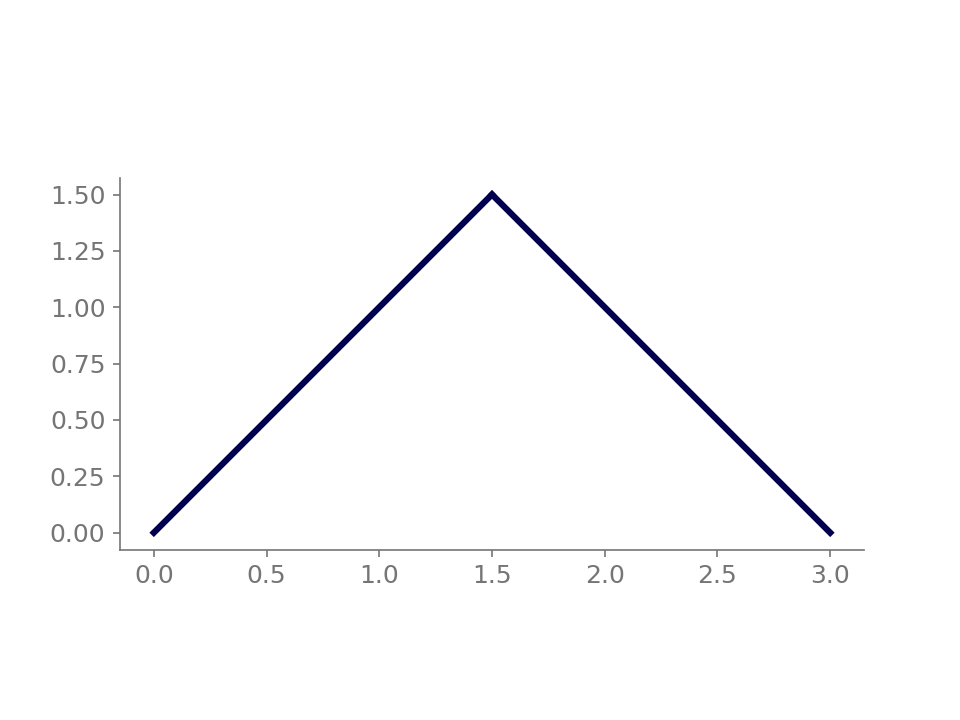

In [10]:
plot_truss(nodes, elements, mats)

## Iteraciones
A conitnuación se describen de manera completa algunas iteraciones. Para el primer incremento se explica cada paso de la iteración.

### Incremento 1

Asuma estado de equilibrio conocido y dado por: ${}^0X$ , ${}^0F$ and ${}^0U$ .

Calcule $K=K({}^0X)$ para la configuración conicida ${}^0X$, aplique el incremento $\triangle F$ y resuelva:

$$
\left[K({}^0X)\right]\left\{\triangle U\right\}=\left\{\triangle F\right\}
$$

para determinar el incremento $\triangle U$.

In [11]:
ini_x = nodes[2, 2]
KG = assembly(elements, mats, nodes, neq, DME_mat)
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

[ 0.         -0.15018948]


Actualice:

$$
X_i \leftarrow{}^0X+\triangle U
$$

Recalcule $K=K(X_i)$

y calcue el residual:

$$
R = \triangle F-K(X_i)\triangle U
$$

In [12]:
nodes[2, 2] = ini_x + delu[1]
UG[1] = nodes[2, 2] - ini_x
KG = assembly(elements, mats, nodes, neq, DME_mat)
R = RHSG - KG.dot(UG)
print(R)

[ 0.         -0.41952316]


Haga:

$$
\triangle F \leftarrow R
$$

y resuelva:

$$
\left[K\right]\left\{\triangle U\right\}=\left\{\triangle F\right\}
$$

para el nuevo incremento $\triangle U$.

In [13]:
loads[0, 2] = R[1]
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

[ 0.         -0.00945998]


If $\triangle U < Tol$ Then (equilibrio):

Almacene la solución:


$$
{}^1X \leftarrow X_i
$$

$$
{}^1U \leftarrow {}^1X - {}^0X
$$

$$
{}^1F \leftarrow  \triangle F
$$


Else

Actualice:

$$
X_{i+1}\leftarrow{} X_i+\triangle U
$$


$$
U \leftarrow X_{i+1} - {}^0X
$$

Recalcule $K=K(X_{i+1})$


Calcule residual:

$$
R = \triangle F-K(X_{i+1}) U
$$


y resuelva:

$$
\left[K\right]\left\{\triangle U\right\}=\left\{R\right\}
$$

para determinar un nuevo incremento $\triangle U$ hasta alcanzar convergencia.

In [14]:
nodes[2, 2] = nodes[2, 2] + delu[1]
print(nodes[2, 2])
UG[1] = nodes[2, 2] - ini_x
KG = assembly(elements, mats, nodes, neq, DME_mat)
R = RHSG - KG.dot(delu)
print(R)
#
loads[0, 2] = R[1]
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

1.3403505416069965
[ 0.        -0.0019513]
[ 0.0000000e+00 -4.4206067e-05]


In [15]:
nodes[2, 2] = nodes[2, 2]
UG[1] = nodes[2, 2] - ini_x
print(UG)
print(nodes[2, 2])

[ 0.         -0.15964946]
1.3403505416069965


### Incremento 2

In [16]:
ini_x = nodes[2, 2]
KG = assembly(elements, mats, nodes, neq, DME_mat)
loads = np.loadtxt('files/Cloads.txt', ndmin=2)
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

[ 0.         -0.16039549]


In [17]:
nodes[2, 2] = ini_x + delu[1]
UG[1] = nodes[2, 2] - ini_x
KG = assembly(elements, mats, nodes, neq, DME_mat)
R = RHSG - KG.dot(UG)
print(R)

[ 0.         -0.65474157]


In [18]:
loads[0, 2] = R[1]
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

[ 0.         -0.01634449]


In [19]:
nodes[2, 2] = nodes[2, 2] + delu[1]
print(nodes[2, 2])
UG[1] = nodes[2, 2] - ini_x
KG = assembly(elements, mats, nodes, neq, DME_mat)
R = RHSG-KG.dot(delu)
print(R)
#
loads[0, 2] = R[1]
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

1.1636105543819666
[ 0.        -0.0078351]
[ 0.         -0.00019796]


In [20]:
nodes[2, 2] = nodes[2, 2]
UG[1] = nodes[2, 2] - ini_x
print(UG)
print(nodes[2, 2])

[ 0.         -0.17673999]
1.1636105543819666


### Incremento 3

In [21]:
ini_x = nodes[2, 2]
KG = assembly(elements, mats, nodes, neq, DME_mat)
loads = np.loadtxt('files/Cloads.txt', ndmin=2)
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

[ 0.        -0.1788806]


In [22]:
nodes[2, 2] = ini_x + delu[1]
UG[1] = nodes[2, 2] - ini_x
KG = assembly(elements, mats, nodes, neq, DME_mat)
R = RHSG-KG.dot(UG)
print(R)

[ 0.         -1.07509943]


In [23]:
loads[0, 2] = R[1]
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

[ 0.         -0.03202625]


In [24]:
nodes[2, 2] = nodes[2, 2] + delu[1]
print(nodes[2, 2])
UG[1] = nodes[2, 2] - ini_x
KG = assembly(elements, mats, nodes, neq, DME_mat)
R = RHSG-KG.dot(delu)
print(R)
#
loads[0, 2] = R[1]
RHSG = loadasem(loads, IBC, neq, 1)
delu = np.linalg.solve(KG, RHSG)
print(delu)

0.9527037093117487
[ 0.         -0.03898688]
[ 0.         -0.00120508]


In [25]:
nodes[2, 2] = nodes[2, 2]
UG[1] = nodes[2, 2] - ini_x
print(UG)
print(nodes[2, 2])

[ 0.         -0.21090685]
0.9527037093117487


## Problema

<div class="alert alert-warning">
    
Implemente un algoritmo que realice de manera automática los pasos de cada incremento y aplique el mismo para determinar al menos 5 configuraciones equilibradas.
 
</div>


## Formato del notebook

La siguiente celda cambia el formato del Notebook.

In [26]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./nb_style.css', 'r').read()
    return HTML(styles)


css_styling()